# Fourier Transforms and Analysis

In the last lecture, we discussed the basics of Fourier Series and looked into computing the coefficients of trigonometric decomposition for a few simple waveforms (square and sawtooth). 

Today, we will make the connections between Fourier Series and Fourier Transforms, discuss and evaluate the Discrete and Fast Fourier Tranforms (DFT and FFT, respectively), and look at a few applications in context.

Table of Contents
1. [History](#History)
1. [Square wave](#square-wave)
   1. [Boilerplate stuff](#Boilerplate-stuff)
   1. [Coding the Fourier Series](#Coding-the-Fourier-Series)
   1. [Plotting the SquareFourier series](#Plotting-the-SquareFourier-series)
1. [Fourier transforms](#Fourier-transforms)
   1. [Discrete Fast Fourier Transform](#Discrete-Fast-Fourier-transform)
   1. [Sampling simple sin function](#Sampling-the-temperature-of-a-bar-of-lengh-L)

## History

Fourier was actually investigating the Heat Equation when he developed the revolutionary approach that now bears his name.

From [Wikipedia](https://en.wikipedia.org/wiki/Joseph_Fourier):

> In 1822 Fourier published his work on heat flow in Théorie analytique de la chaleur (The Analytical Theory of Heat), in which he based his reasoning on Newton's law of cooling, namely, that the flow of heat between two adjacent molecules is proportional to the extremely small difference of their temperatures.

He determined that the solution can be expanded in terms of sines and cosines:

$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n \cos(nx) + b_n \sin(nx)
$$


## Square wave

Let's use our result from last time to look at this in more detail:

$$
a_n =\frac{2}{n\pi}\sin \left(n \omega_0 \frac{\pi}{2} \right)
$$

What we want is the equivalent of the following:

In [ ]:
from IPython.display import Image
Image(url='Fourier_Transform.gif')  

---
# DISCUSSION

1. How many terms will we need to accurately approximate the square wave that we discussed last time?

---

### Boilerplate stuff

To find out, let's first load the libraries as usual

In [1]:
%matplotlib inline
import numpy as np
import scipy.signal as signal    # Notice this one is new!
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
from mpl_toolkits.mplot3d import Axes3D
import math
import cmath

And define some useful variables

In [ ]:
pi = np.pi
x  = np.linspace(-4*pi, 4*pi, 1000)

### Coding the Fourier Series

Now, let's adapt the "Fourier Function" that we had before for the sawtooth wave, but now for the square wave:

Recall, that we determined that the __sawtooth wave__ Fourier Series looks like this:

$$
\begin{align}
s(x)&={\frac {a_{0}}{2}}+\sum _{m=1}^{\infty }\left[a_{m}\cos \left(mx\right)+b_{n}\sin \left(mx\right)\right]\\
&={\frac {2}{\pi }}\sum _{m=1}^{\infty }{\frac {(-1)^{m+1}}{m}}\sin(mx),\quad \mathrm {for} \quad x-\pi \notin 2\pi \mathbf {Z} 
\end{align}
$$

In [ ]:
def SawtoothFourier(M,T,t):                  # M = number waves, T = period, t = time
    sumy  = 0                                # initialize the output                 
    omega = 2.*np.pi/T                       # Omega = 2pi/T
    sign  = 1                                # Sign of the coefficient                                     
    for m in range(1,M):                     # Number of terms to include
        sumy += (sign/m) * np.sin(m*omega*t) # value of the function after adding next term                     
        sign = -sign                         # swap the sign of the coefficient    
    sumy = (2.0/np.pi)*sumy                  # Common factor in front of the sum
    return sumy

--- 
# DISCUSSION

1. Code up your own `SquareFourier` based on this example
1. How many terms do we need to get the same picture as from Wikipedia?
---

In [ ]:
def SquareFourier(M,T,t):                                         # M = number modes to include, T = period, t = time
    sumy  = 0                                                     # initialize the output                 
    omega = 2.*pi/T  # Omega = 2pi/T
    coeffarray = [(0,0.5)]
    for m in range(1,M):                                         # Loop over only odd modes
        coeff = (2./(m*pi))*np.sin(m*omega*pi/2.)
        coeffarray.append((m,coeff))
        sumy += coeff*np.cos(m*t)                           # value of the function after adding next term   
    sumy += 0.5
    return sumy, coeffarray

### Plotting the SquareFourier series

We can reuse basically everything from before|

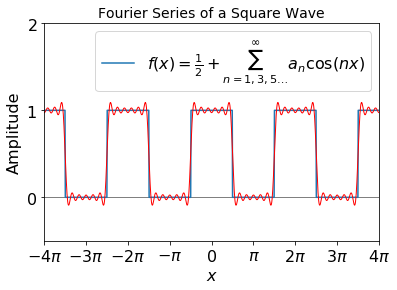

In [13]:
plt.axhline(0, color='gray', lw=1)

squarewave = 0.5 + 0.5 * signal.square(x + pi/2)

plt.plot(x, squarewave, lw=1.5, label=r'$f(x)=\frac{1}{2} + \sum_{n=1,3,5\ldots}^{\infty}a_n \cos(nx)$')

s, coeffs = SquareFourier(12, 2*pi, x)   
lines, = plt.plot(x, s, lw=1, color='red')

plt.yticks([-1, 0, 1, 2], ['$-1$', '$0$', '$1$', '$2$'])
plt.xticks([-4*pi, -3*pi, -2*pi, -1*pi, 0, pi, 2*pi, 3*pi, 4*pi], ['$-4\pi$', '$-3\pi$', '$-2\pi$', '$-\pi$', '$0$', '$\pi$', '$2\pi$', '$3\pi$', '$4\pi$'])
plt.xlim(-4*pi, 4*pi)
plt.ylim(-0.5, 2)
plt.rcParams.update({'font.size': 16})
plt.title('Fourier Series of a Square Wave', fontsize=14)
plt.xlabel('$x$')
plt.ylabel('Amplitude')
plt.legend(fontsize=16, fancybox=True, loc='best')
plt.show()

[(0, 0.5), (1, 0.6366197723675814), (2, 3.8981718325193755e-17), (3, -0.2122065907891938), (4, -3.8981718325193755e-17), (5, 0.12732395447351627), (6, 3.8981718325193755e-17), (7, -0.09094568176679733), (8, -3.8981718325193755e-17), (9, 0.0707355302630646), (10, 3.8981718325193755e-17), (11, -0.057874524760689224)]


(-0.5, 2)

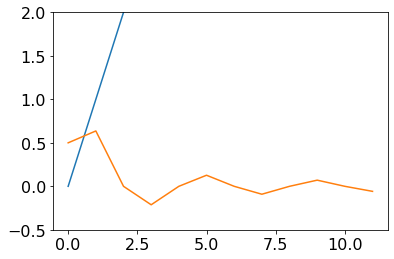

In [19]:
print(coeffs)
plt.plot(coeffs)
plt.ylim(-0.5, 2)

## Fourier transforms

Let's take what we discussed and use it!

### Discrete Fast Fourier transform

In [2]:
def fft(data):
    
    N = len(data)
    if N <= 1:               # transform is trivial
        return data

    even = fft(data[0::2])
    odd  = fft(data[1::2])
    
    T = [np.exp(-2j*np.pi*k/N)*odd[k] for k in range(N//2)]
    
    part1 = [even[k] + T[k] for k in range(N//2)]
    part2 = [even[k] - T[k] for k in range(N//2)]
    
    return part1 + part2


### Sampling the temperature of a bar of lengh L

Suppose you take a bar of length $L$ which is kept at a constant temperature at the ends and you want to measure the temperature at $N$ equally spaced points such that the positions of those points are given by

$$
x_j = \frac{L}{N}j
$$

and enumerated by the index $j$. Since the usual modes of the sinusoid that will provide a solution to the heat equation with fixed end points is given by

$$
\sin\left(\frac{n \pi x}{L}\right)
$$

We can translate this into a discretized for by replacing the $x \rightarrow x_j$. Therefore, we can write the function that describes this temperature as a $\sin$ function:

$$
f_k = \sin\left(\frac{2\pi f_n k}{N}\right)
$$

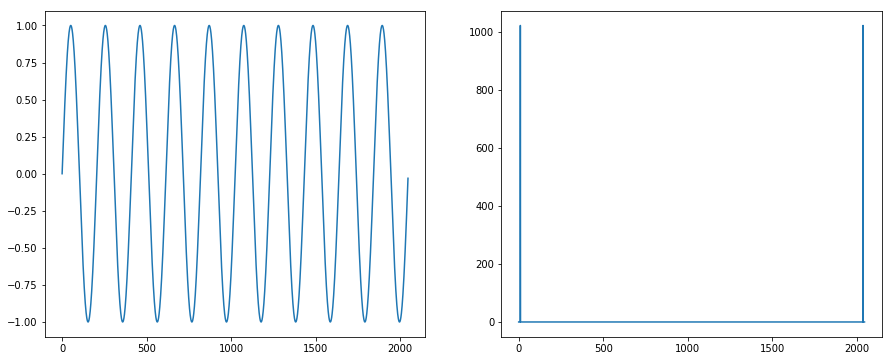

In [3]:
N = 2048
f = 10.0

t = np.array( [ float(i) for i in range(N) ])
y = np.array( [ math.sin(2*np.pi*f*ti / float(N)) for ti in t] )

Y = fft(y)

Yre = [ math.sqrt(Y[i].real**2 + Y[i].imag**2) for i in range(N) ]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))

ax1.plot(t, y)
ax2.plot(t, Yre)
#ax2.set_xlim(498,510)